In [1]:
import sys
sys.path.append("../")
from utils import DATA, BENCHMARK_TABLE

In [2]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/lucas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import pandas as pd
import re
import numpy as np
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, chi2

In [4]:
german_stopwords = set(stopwords.words('german'))

In [5]:
SEED=42

In [6]:
df = pd.read_parquet(f"{DATA}/de_poems.parquet")
df = df.astype({"title": "string", "text": "string", "author": "string", "creation": "int64"})
df.dtypes

title       string[python]
text        string[python]
author      string[python]
creation             int64
dtype: object

In [7]:
df["century"] = (df["creation"] // 100) + 1

In [8]:
def preprocess(text: str) -> str:
    text = text.lower()
    text = re.sub(r'[\d\W_]+', ' ', text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in german_stopwords]
    return ' '.join(tokens)

df['cleaned_text'] = df['text'].map(preprocess)

In [9]:
X = df['cleaned_text'].values
y = df['century'].values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [11]:
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(zip(np.unique(y), class_weights))
sample_weight = np.array([class_weight_dict[class_label] for class_label in y_train])

In [12]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,1), max_df=0.9, min_df=3)),
    ('select', SelectKBest(chi2, k=6000)),
    ('clf', MultinomialNB(alpha=0.1))
])

param_grid = {
    #'tfidf__ngram_range': [(1,1), (1,2)],
    #'tfidf__max_df': [0.9, 1.0],
    #'clf__alpha': [0.01, 0.2],
    #'select__k': [1000, 2000, 3000, 4000, 5000],
}

grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=4
)

In [13]:
grid.fit(X_train, y_train, clf__sample_weight=sample_weight)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_df=0.9, min_df=3)),
                                       ('select',
                                        SelectKBest(k=6000,
                                                    score_func=<function chi2 at 0x72e073601620>)),
                                       ('clf', MultinomialNB(alpha=0.1))]),
             n_jobs=4, param_grid={}, scoring='accuracy', verbose=1)

In [14]:
y_pred = grid.predict(X_test)
print("Best Parameters:", grid.best_params_)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best Parameters: {}

Classification Report:
               precision    recall  f1-score   support

          11       0.11      0.56      0.19        55
          13       0.07      0.56      0.12        18
          14       0.35      0.86      0.49       189
          16       0.49      0.78      0.60       210
          17       0.91      0.86      0.88      4032
          18       0.65      0.64      0.64      2880
          19       0.84      0.71      0.77      6476
          20       0.30      0.70      0.42       454

    accuracy                           0.74     14314
   macro avg       0.47      0.71      0.52     14314
weighted avg       0.79      0.74      0.76     14314



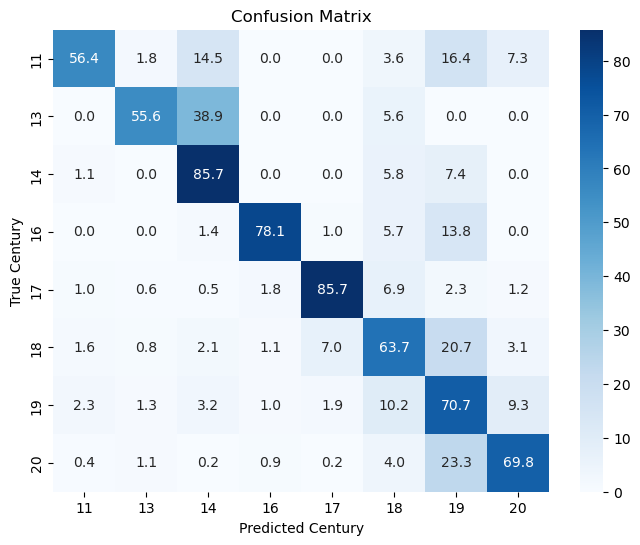

In [15]:
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

centuries = sorted(np.unique(np.concatenate((y_test, y_pred))))

plt.figure(figsize=(8,6))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap='Blues', xticklabels=centuries, yticklabels=centuries)
plt.xlabel('Predicted Century')
plt.ylabel('True Century')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# Compare the results with the actual y values
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.74


In [17]:
# Use predict_proba to get probabilities for each class
y_pred_proba = grid.predict_proba(X_test)

# Compute ROC AUC score
avg_roc = roc_auc_score(y_test, y_pred_proba, average="macro", multi_class="ovr")
print(f"ROC AUC: {avg_roc:.2f}")

ROC AUC: 0.93


In [18]:
print(classification_report(y_test,y_pred, zero_division=0))

results = classification_report(y_test, y_pred, zero_division=0, output_dict=True)

recall_avg = results["weighted avg"]["recall"]
f1_score_avg = results["weighted avg"]["f1-score"]
precision_avg = results["weighted avg"]["precision"]

              precision    recall  f1-score   support

          11       0.11      0.56      0.19        55
          13       0.07      0.56      0.12        18
          14       0.35      0.86      0.49       189
          16       0.49      0.78      0.60       210
          17       0.91      0.86      0.88      4032
          18       0.65      0.64      0.64      2880
          19       0.84      0.71      0.77      6476
          20       0.30      0.70      0.42       454

    accuracy                           0.74     14314
   macro avg       0.47      0.71      0.52     14314
weighted avg       0.79      0.74      0.76     14314



In [22]:
benchmark = pd.read_parquet(BENCHMARK_TABLE, engine="fastparquet")
benchmark.loc[("TF-IDF", "Naive Bayes"), ["Avg Recall", "Avg F1-Score", "Avg Precision", "Accuracy", "Avg AUC", "Avg Training time (m)"]] = [
    recall_avg, f1_score_avg, precision_avg, accuracy, avg_roc, 0.17
]

In [23]:
benchmark

Accuracy  Avg Precision  \
Encoding Model                                                            
TF-IDF   Bagging - Logistic Regression          0.515859       0.728819   
         Feedforward Neural Network             0.870896       0.869331   
         Logistic Regression                    0.851125       0.850301   
         Naive Bayes                            0.737390       0.791740   
         Random Forest                          0.776513       0.776507   
         Recurrent Neural Network               0.000000       0.000000   
         Stacking - Random Forest / KNeighbors  0.820246       0.819690   
Word2Vec Feedforward Neural Network             0.000000       0.000000   
         Logistic Regression                    0.784547       0.816938   
         Multi-Layer Perceptron                 0.840506       0.837564   
         Naive Bayes                            0.000000       0.000000   
         Random Forest                          0.814028       0.809732   
         Recurrent Neural Network               0.717968       0.793872   

                                                Avg Recall  Avg F1-Score  \
Encoding Model                                                             
TF-IDF   Bagging - Logistic Regression            0.515859      0.569268   
         Feedforward Neural Network               0.870896      0.868993   
         Logistic Regression                      0.851125      0.850428   
         Naive Bayes                              0.737390      0.756293   
         Random Forest                            0.776513      0.759780   
         Recurrent Neural Network                 0.000000      0.000000   
         Stacking - Random Forest / KNeighbors    0.820246      0.808860   
Word2Vec Feedforward Neural Network               0.000000      0.000000   
         Logistic Regression                      0.784547      0.794427   
         Multi-Layer Perceptron                   0.840506      0.838563   
         Naive Bayes                              0.000000      0.000000   
         Random Forest                            0.814028      0.809036   
         Recurrent Neural Network                 0.717968      0.730375   

                                                 Avg AUC  \
Encoding Model                                             
TF-IDF   Bagging - Logistic Regression          0.890785   
         Feedforward Neural Network             0.980472   
         Logistic Regression                    0.976420   
         Naive Bayes                            0.932115   
         Random Forest                          0.927325   
         Recurrent Neural Network               0.000000   
         Stacking - Random Forest / KNeighbors  0.962778   
Word2Vec Feedforward Neural Network             0.000000   
         Logistic Regression                    0.959170   
         Multi-Layer Perceptron                 0.983007   
         Naive Bayes                            0.000000   
         Random Forest                          0.946552   
         Recurrent Neural Network               0.965358   

                                                Avg Training time (m)  
Encoding Model                                                         
TF-IDF   Bagging - Logistic Regression                           0.50  
         Feedforward Neural Network                              0.00  
         Logistic Regression                                     0.00  
         Naive Bayes                                             0.17  
         Random Forest                                           0.00  
         Recurrent Neural Network                                0.00  
         Stacking - Random Forest / KNeighbors                  20.00  
Word2Vec Feedforward Neural Network                              0.00  
         Logistic Regression                                     0.00  
         Multi-Layer Perceptron                                  0.00  
         Naive B

In [24]:
# Save the benchmark table
benchmark.to_parquet(BENCHMARK_TABLE, index=True)